# Проект 5. Компьютер говорит «Нет»

## Описание проекта

Наша задача написать скоринговую модель предсказания дефолта клиентов банка.

Проект выполнил Бердюгин Евгений, DSPR-40

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

## Загрузка библиотек и данных

In [1150]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter('ignore')

Загрузим наши датасеты

In [1227]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

Зафиксируем Random seed и версию пакетов, для воспроизводимости пакетов

In [1228]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

Объединяем датасеты

In [1229]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['default'] = 0 # в тесте у нас нет значения Default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#сохраним id клиентов, для отправки результатов на Kaggle 
client_id = pd.DataFrame(data['client_id'])
sample = pd.DataFrame(data['sample'])
default = pd.DataFrame(data['default'])
data = data.drop('client_id', axis=1)

#сделаем файл для сравнивания метрик моделей
data_report = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'support', 'confusion_matrix'])

## Функции

In [1230]:
#Функция определения выбросов
def detect_outliers(column):
    '''Function is called to detect outliers'''
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum(), (column > max_out).sum()

## EDA

Разведывательный анализ сделан с помощью библиотеки pandasprofiling.
Ссылка на ноутбук [Pandas.profiling_for_Project_5.ipynb](https://github.com/EvgeniyBerdyugin/SkillFactory-dspr-40/blob/main/module_5/Pandas.profiling_for_Project_5.ipynb). Так же в [репозитории](https://github.com/EvgeniyBerdyugin/SkillFactory-dspr-40/tree/main/module_5) есть HTML файл с результатами EDA.

In [1231]:
#разделим признаки на категории
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating','home_address', 'work_address',
            'sna','first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

Посмотрим выбросы

In [1232]:
for col in data[num_cols]:
    print(col, ' - кол-во выбросов в нижней границе - ', detect_outliers(data[col])[0],';', 
          'кол-во выбросов в верхней границе - ', detect_outliers(data[col])[1])

age  - кол-во выбросов в нижней границе -  0 ; кол-во выбросов в верхней границе -  0
decline_app_cnt  - кол-во выбросов в нижней границе -  0 ; кол-во выбросов в верхней границе -  18677
income  - кол-во выбросов в нижней границе -  0 ; кол-во выбросов в верхней границе -  7000
bki_request_cnt  - кол-во выбросов в нижней границе -  0 ; кол-во выбросов в верхней границе -  2636
score_bki  - кол-во выбросов в нижней границе -  82 ; кол-во выбросов в верхней границе -  436


### Выводы из разведывательного анализа и анализа выбросов:

* app_date имеет не удобный для работы формат, преобразовать в datetime
* education имеет пропуски, категориальная переменная, преобразуем с помощью LabelEncoding
* sex бинарная переменная, преобразуем с помощью LabelEncoding
* age имеет смещенное распределение, переведем в категории или логарифмируем
* car и car_type имеют высокую корреляцию, преобразуем с помощью  LabelEncoding, объеденить эти признаки в один
* decline_app_cnt имеет много нулевых значений, много выбросов, переведем в категории или логарифмируем
* good_work не требует обработки
* score_bki имеет выбросы, попробуем перевести в категориальный признак
* bki_request_cnt имеет много нулевых значений, есть выбросы, переведем в категории или логарифмируем
* region_rating имеет слегка смещенное распределение, преобразуем в более читаемый для модели вид
* home_address и work_address имеют высокую корреляцию, объеденим эти признаки
* income имеет смещенное распределение, есть выбросы, переведем в категории или логарифмируем
* sna и first_time имеют высокую корреляцию, объеденим эти признаки
* foreign_passport бинарная переменная, преобразуем с помощью LabelEncoding
* default целевая переменная. Не сбалансированная выборка. Количество одного класса сильно больше количества второго класса.Пробовать веса классов или добавать в выборку больше значений класса меньшинства.

Обработаем даты

In [1233]:
data['app_date'] = pd.to_datetime(data['app_date'])

Заполним пропуски модой

In [1234]:
mod_edu = data['education'].mode()
data['education'] = data['education'].fillna(mod_edu[0])

### Обучим наивную модель для сравнения - LogisticRegression на стандартных настойках

In [1235]:
data_naive = data[['age',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'sample', 'default']]

In [1236]:
# Теперь выделим тестовую часть
train_data = data_naive.query('sample == 1').drop(['sample'], axis=1)
test_data = data_naive.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

confusion_matrix
[[12933     0]
 [ 1827     0]]


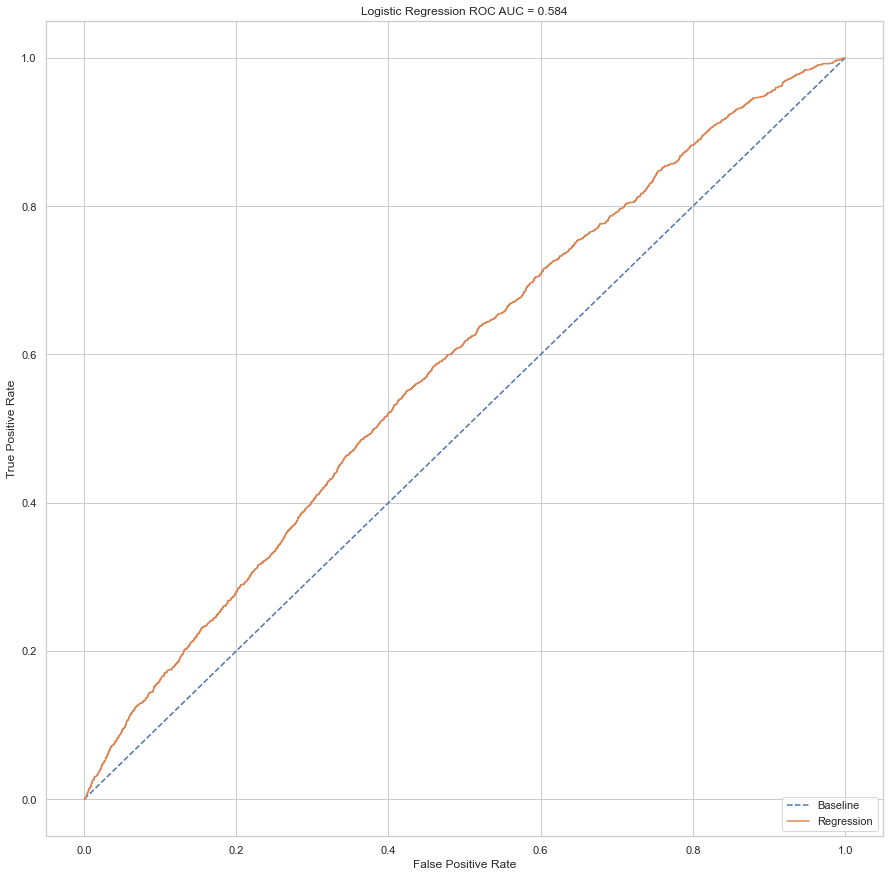

,naive
precision,0.0
recall,0.0
f1-score,0.0
support,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]"


In [1237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


data_report['naive'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['naive']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

precision-recall curve наивной модели выглядит лучше, чем если бы мы использовали случайный выбор, однако она все примеры определила в нулевой класс. Такой результат совлем не подходит для скоринговой модели. Будем пробовать ее улучшать.

## Посмотрим распределение логарифмированных числовых переменных

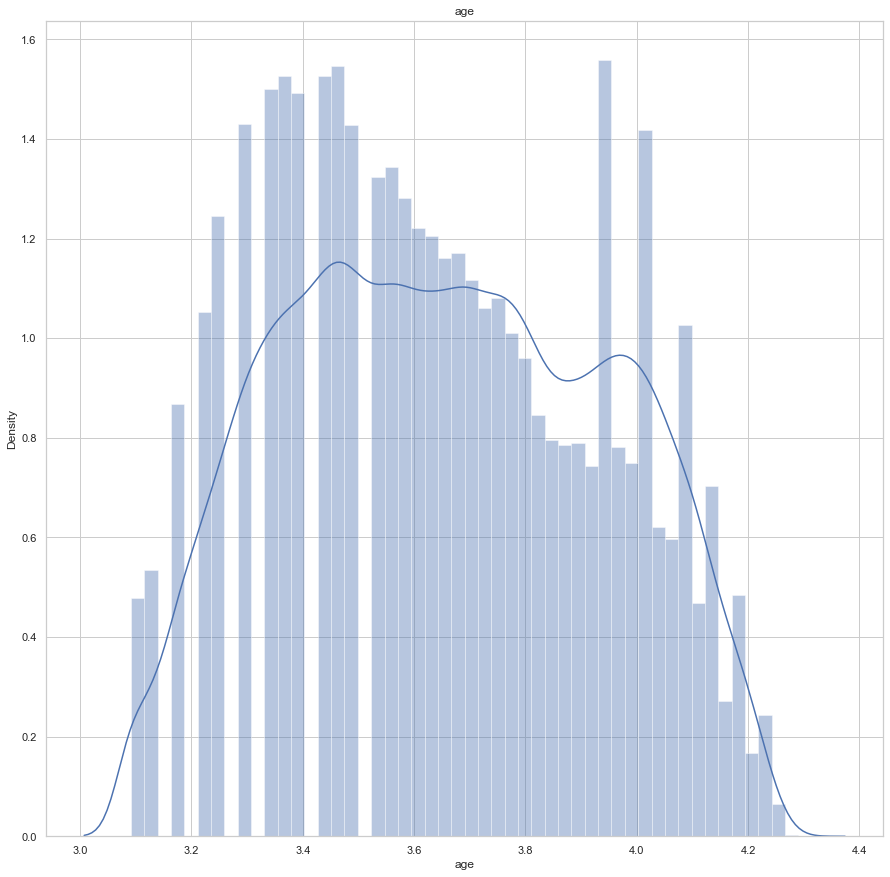

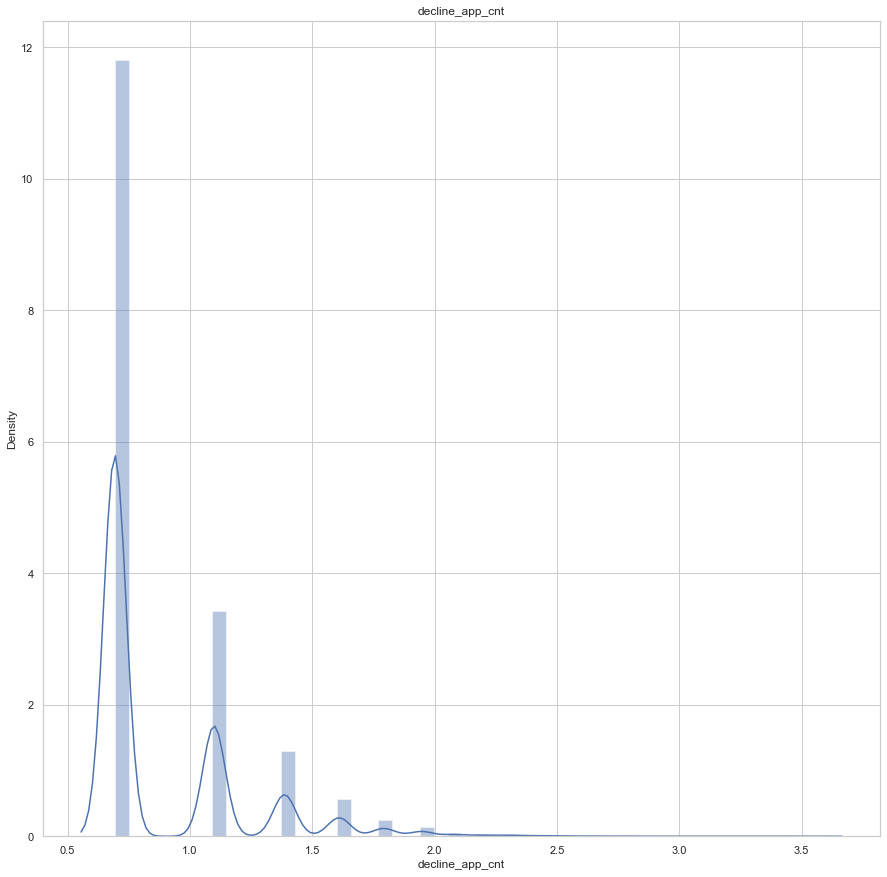

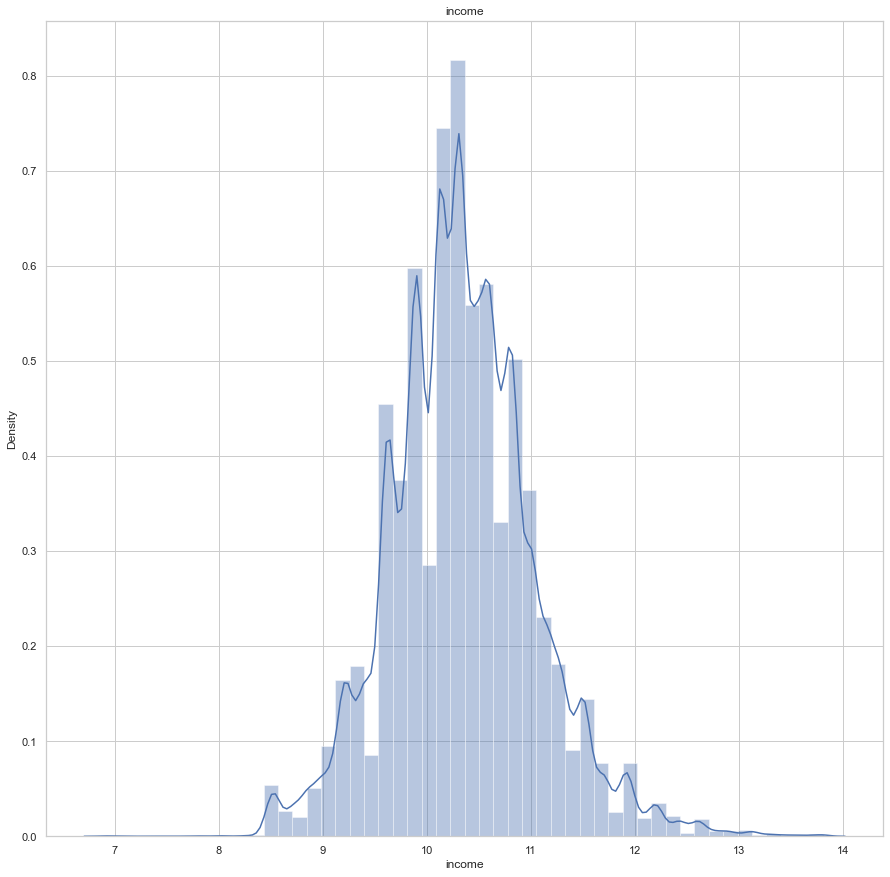

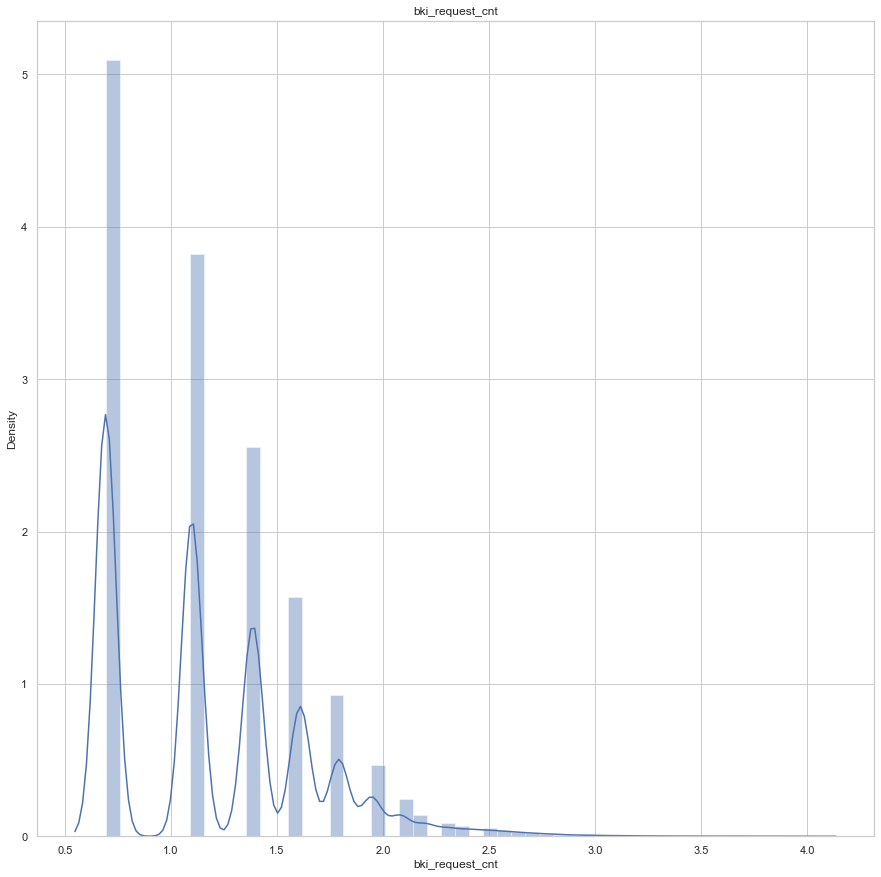

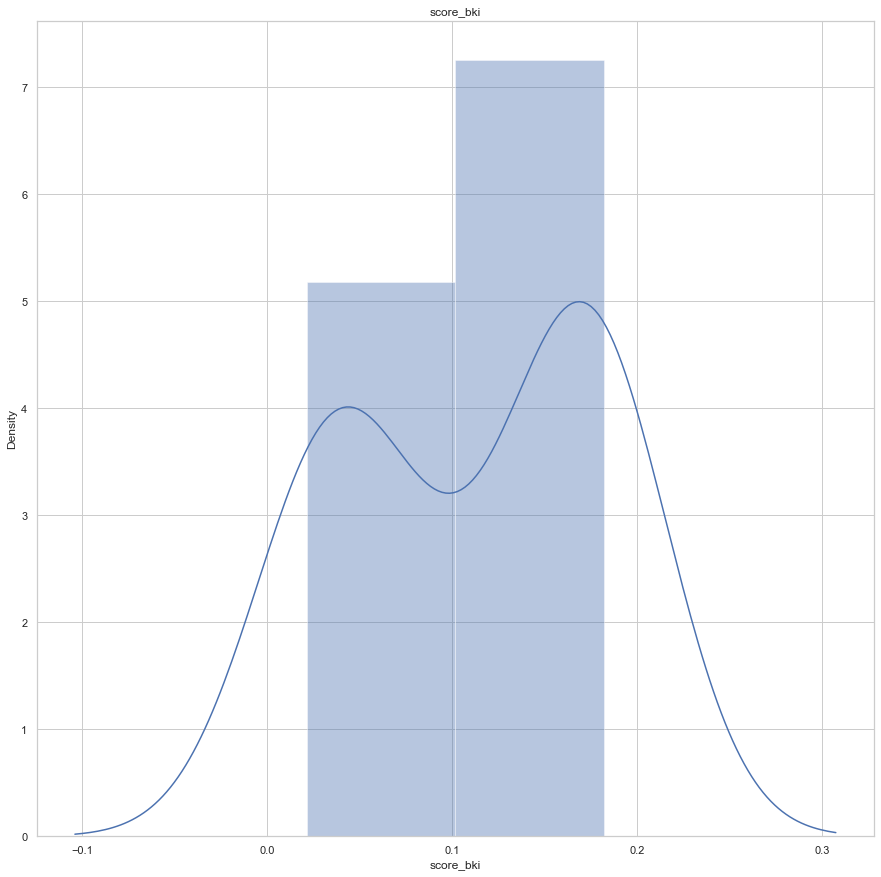

In [1238]:
for col in num_cols:
    plt.figure()
    sns.distplot(np.log(data[col][data[col] > 0].dropna() +1))
    plt.title(col)
    plt.show()

income и age приобрели распределение похожее на нормальное, заменим их логарифмированными значениями

In [1239]:
col_for_log = ['income', 'age']
for col in col_for_log:
    data[col+'_log'] =np.log(data[col])
    num_cols.append(col+'_log')

Сделаем категориальный признак из age

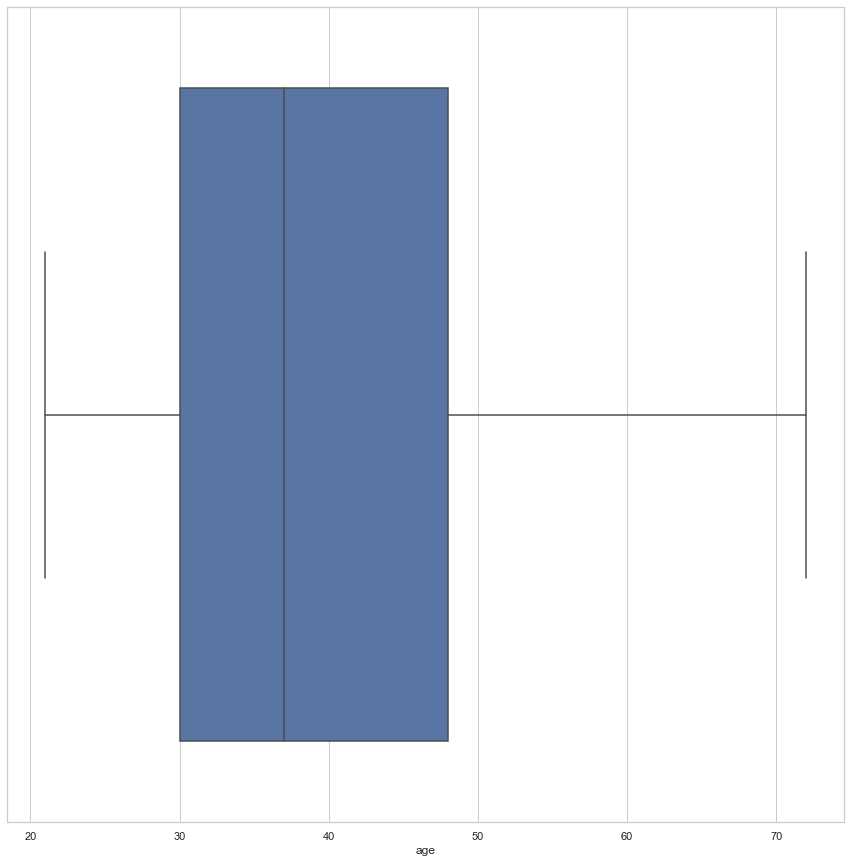

In [1240]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data['age'])
plt.show()

Разделим на 3 категории: ниже межквартильного размаха, значения между первым и третьим квартилями и выше третьего квартиля

In [1241]:
q1, q3 = np.percentile(sorted(data['age']), [25, 75])
data['age_cat'] = data['age'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

посмотрим boxplot числовых признаков

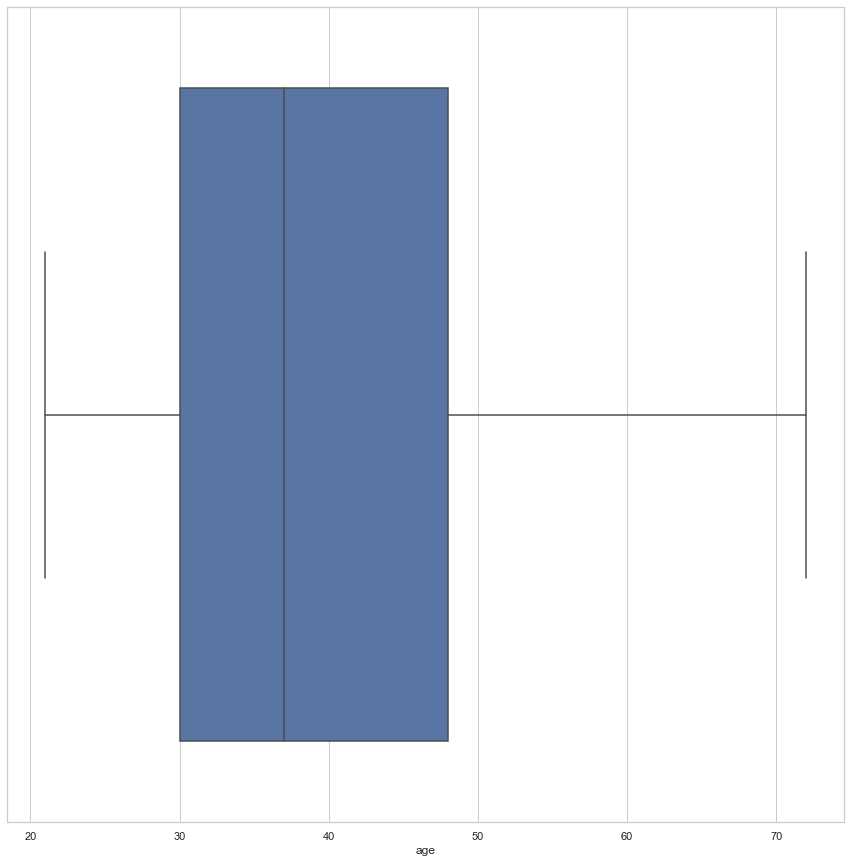

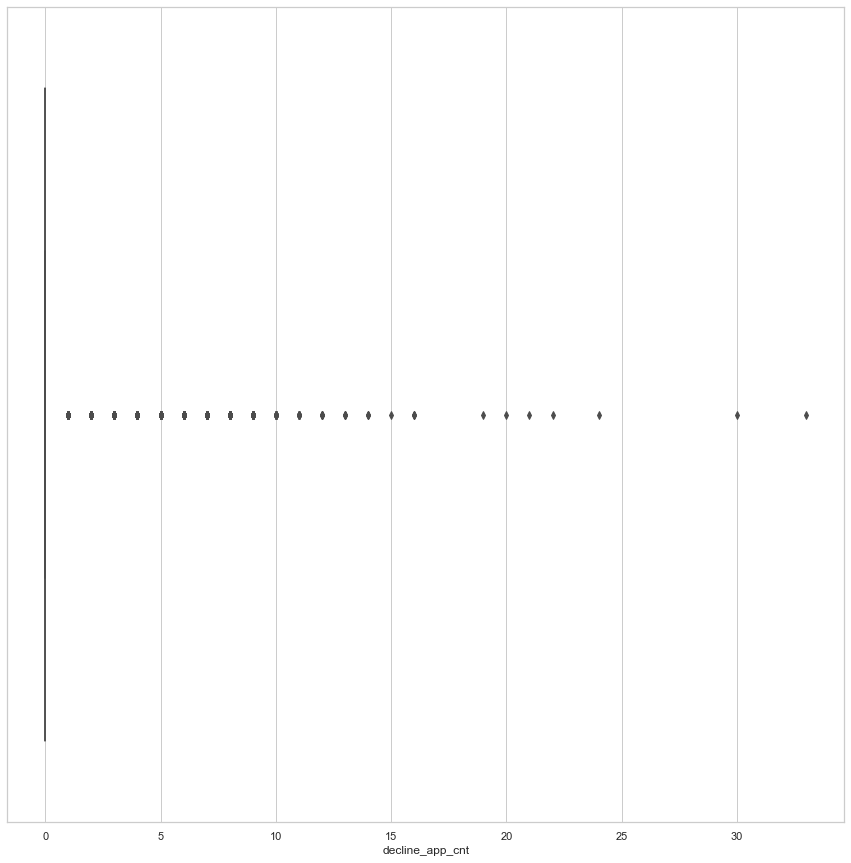

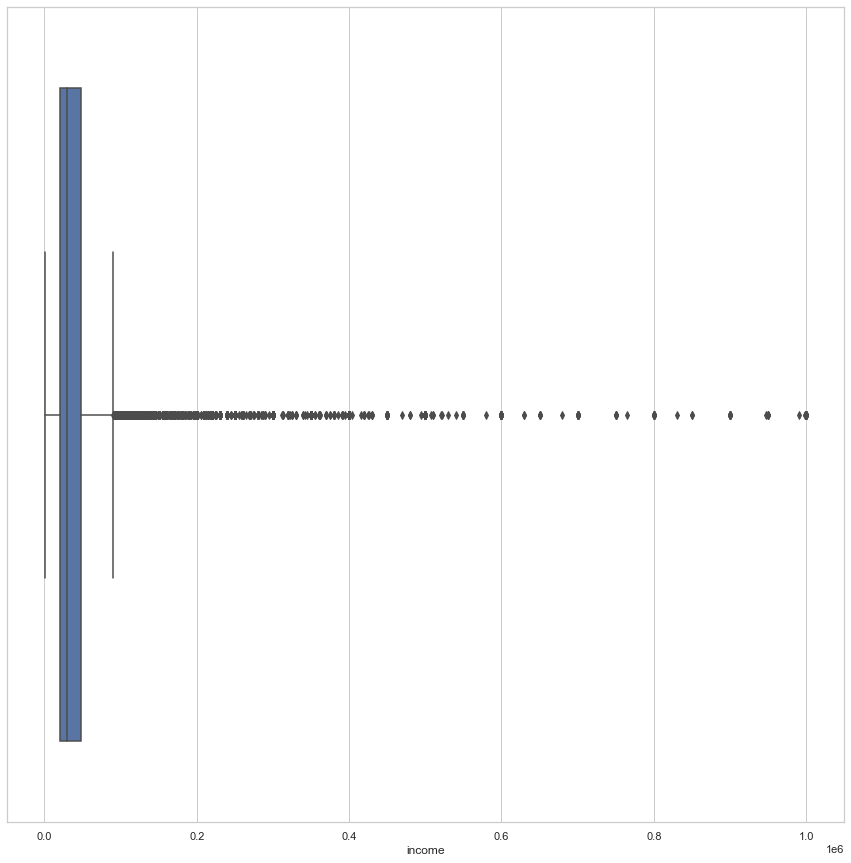

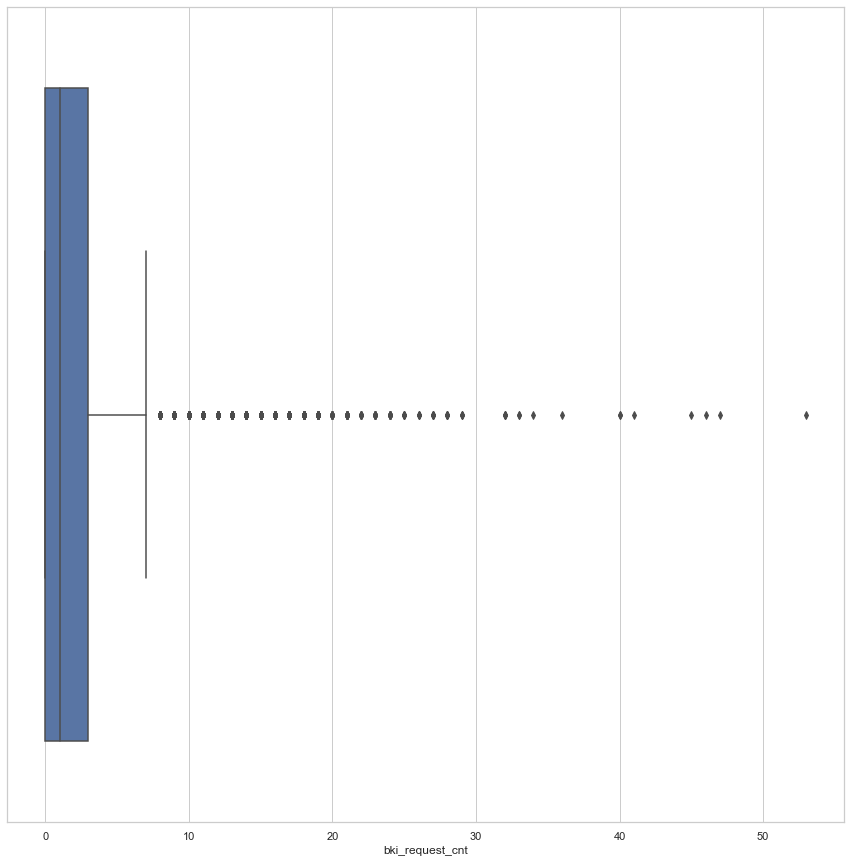

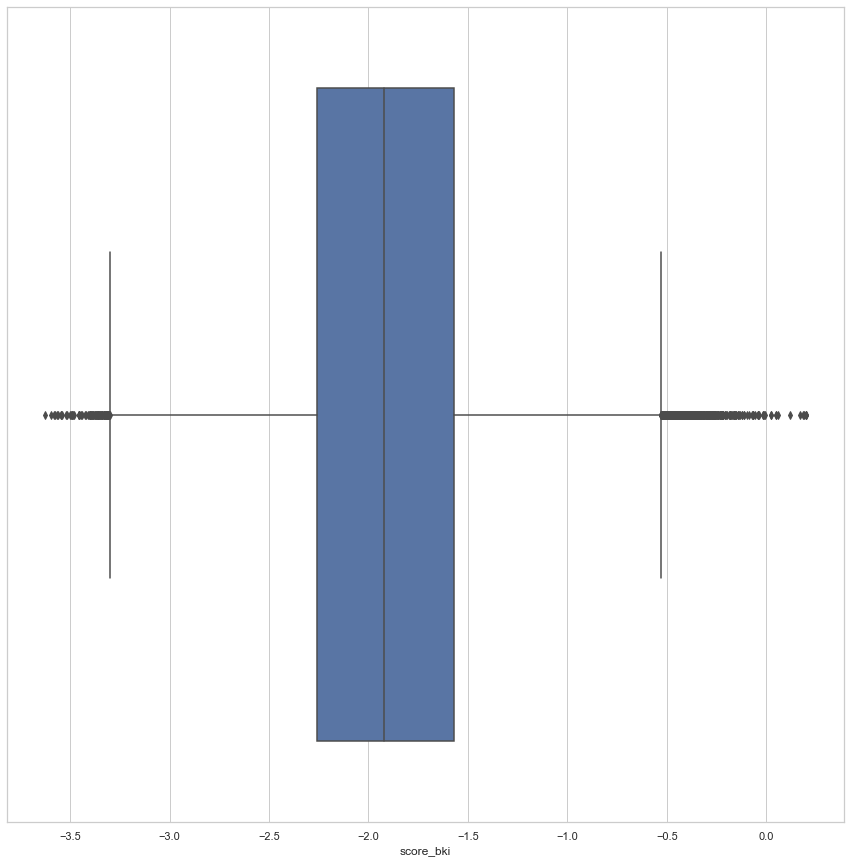

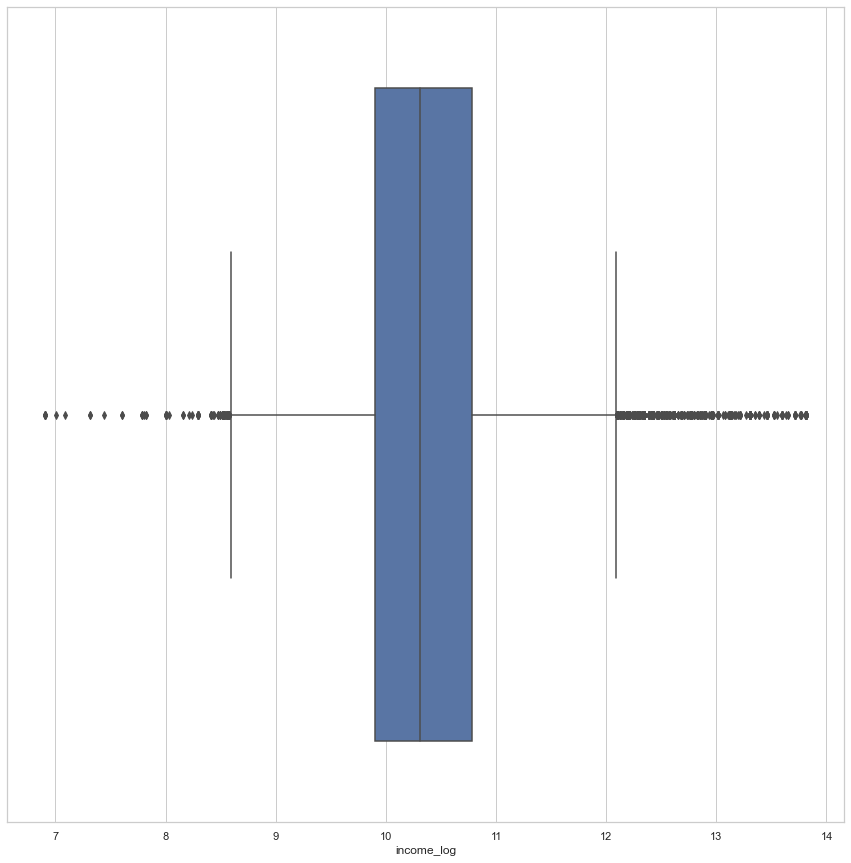

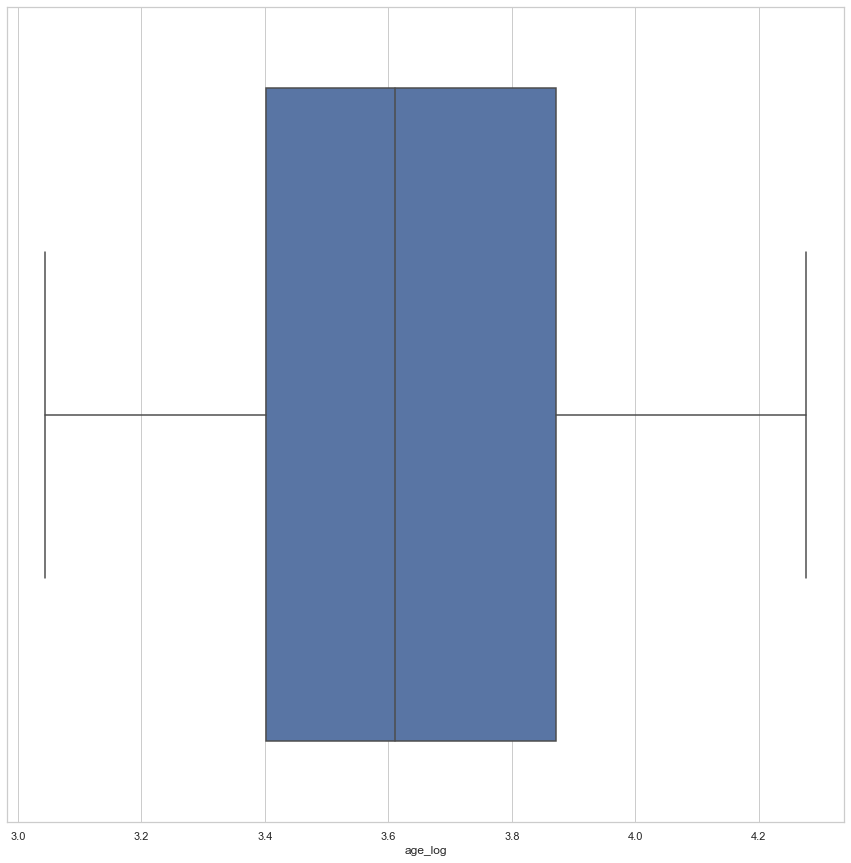

In [1242]:
for i in num_cols:
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=data[i])
    plt.show()

decline_app_cnt имеет большинство нулей разделим ее на две категории: были отказы и не было

In [1243]:
data['decline_app'] = data['decline_app_cnt'].apply(lambda x: 0 if x == 0 else 1)

income имеет сильное смещение и большое количество выбросов. Разделим ее на три категории low, mid и hi (0, 1, 2)

In [1244]:
q1, q3 = np.percentile(sorted(data['income']), [25, 75])
data['income_cat'] = data['income'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

bki_request_cnt имеет большинство значений около 1. Разделим ее на две категории меньше либо равно 1 и больше единицы (0, 1)

In [1245]:
data['bki_request'] = data['bki_request_cnt'].apply(lambda x: 0 if x <= 1 else 1)

## Обработаем бинарные признаки

LabelEncoder для sex, foreign_passport, car, car_type

In [1246]:
label_encoder = LabelEncoder()
data['sex'] = pd.Series(label_encoder.fit_transform(data['sex']))
data['foreign_passport'] = pd.Series(label_encoder.fit_transform(data['foreign_passport']))
data['car'] = pd.Series(label_encoder.fit_transform(data['car']))
data['car_type'] = pd.Series(label_encoder.fit_transform(data['car_type']))

объединим car  и car_type

In [1247]:
data['car_car_type'] = data['car'] + data['car_type']

## Обработаем категориальные признаки

Заменим значения educatoin, значениями от 0 до 4, в зависимости от ранга
образования

In [1248]:
data_edu = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
data['education'] = data['education'].apply(lambda x: data_edu[x])

Объеденим home_adress и work_adress

In [1249]:
data['home_work_address'] = data['home_address'] + data['work_address']

Объединим sna и first_time

In [1250]:
data['sna_first_time'] = data['sna'] + data['first_time']

## Feature engineering

### создадим признаки из даты

In [1251]:
data['year'] = data['app_date'].apply(lambda x: x.year)
data['month'] = data['app_date'].apply(lambda x: x.month)
data['day_of_yar'] = data['app_date'].apply(lambda x: x.timetuple()[7])
data['weekday'] = data['app_date'].apply(lambda x: x.weekday())
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x in (5, 6) else 0)

Посмотрим за какой период данные

In [1252]:
data['year'].value_counts()

2014    110148
Name: year, dtype: int64

только 2014 год. Удилим этот столбец

In [1253]:
data = data.drop('year', axis=1)
data['month'].value_counts(normalize=True)*100

3    28.685950
2    24.600537
4    23.846098
1    22.867415
Name: month, dtype: float64

Данные за 4 месяца, в целом равномерно распределены

In [1254]:
data['weekday'].value_counts(normalize=True)*100

1    16.505066
0    16.212732
2    15.961252
3    15.815993
4    15.205905
5    11.077823
6     9.221230
Name: weekday, dtype: float64

Данные за все дни периода

In [1255]:
data = data.drop('app_date', axis=1)

### Приведем region_rating к значениям от 0 до 6

In [1256]:
data_region = {20: 0, 30: 1, 40: 2, 50: 3, 60: 4, 70: 5, 80: 6}
data['region_rating'] = data['region_rating'].apply(lambda x: data_region[x])

## Проверим корреляции новых признаков

Распределим новые признаки по типам

In [1257]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'decline_app', 'bki_request', 'is_weekend']
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 'income_cat', 
            'car_car_type', 'home_work_address', 'sna_first_time', 'month', 'weekday', 'age_cat']
num_cols = ['age', 'age_log', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'income_log', 'day_of_yar']

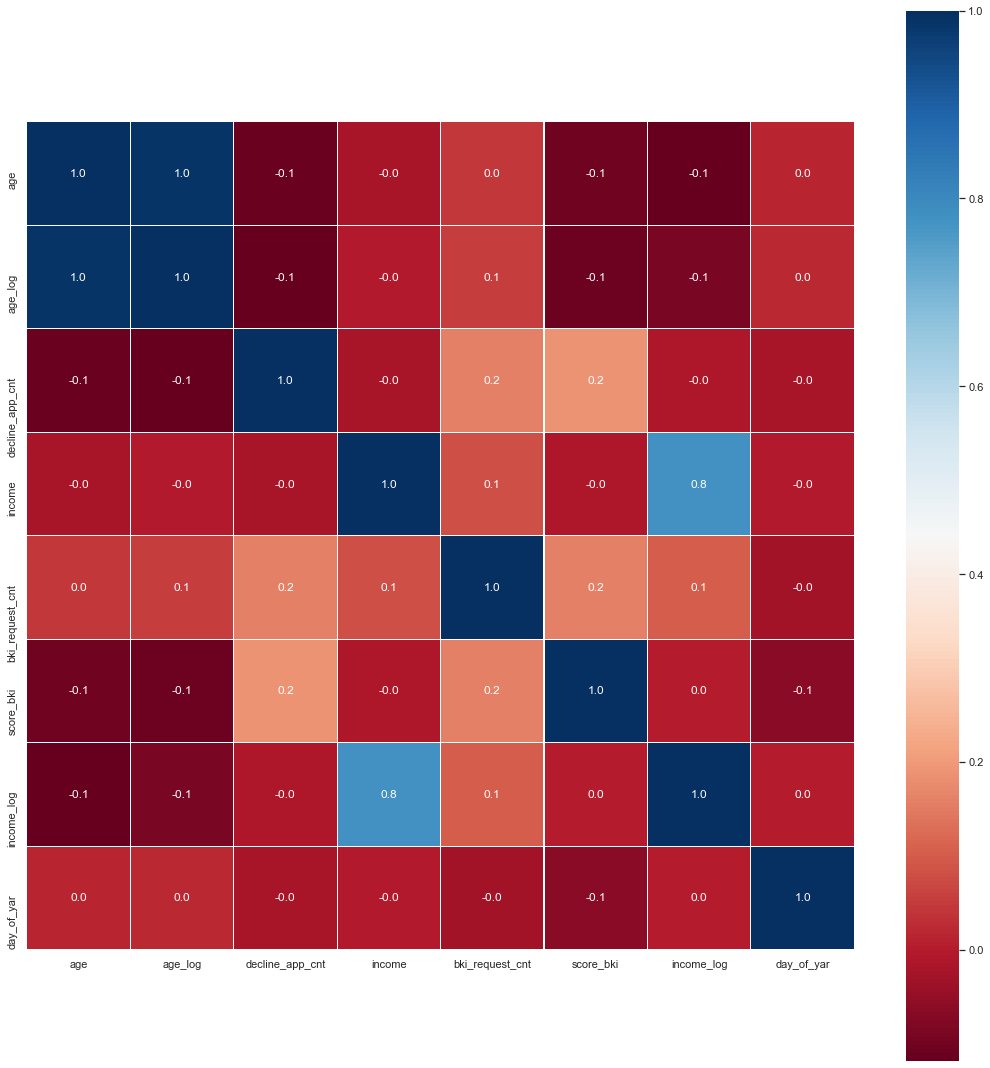

In [1258]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data[num_cols].corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Сильная корреляция между age и age_log, income и income_log. Посмотрим значимость переменных и решим какие из них оставить.

### Посмотрим значимость непрерывных переменных, с помощью f classif функции

<AxesSubplot:>

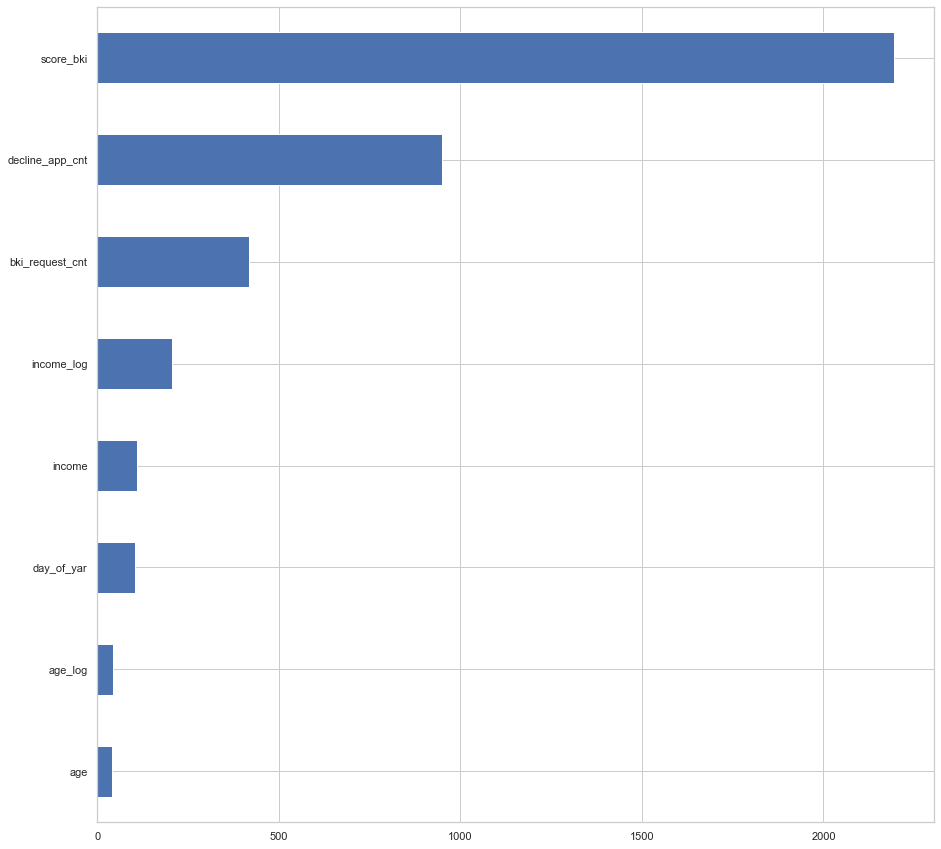

In [1259]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Смотрим значимость категориальных признаков с помощью функции mutual info classif

<AxesSubplot:>

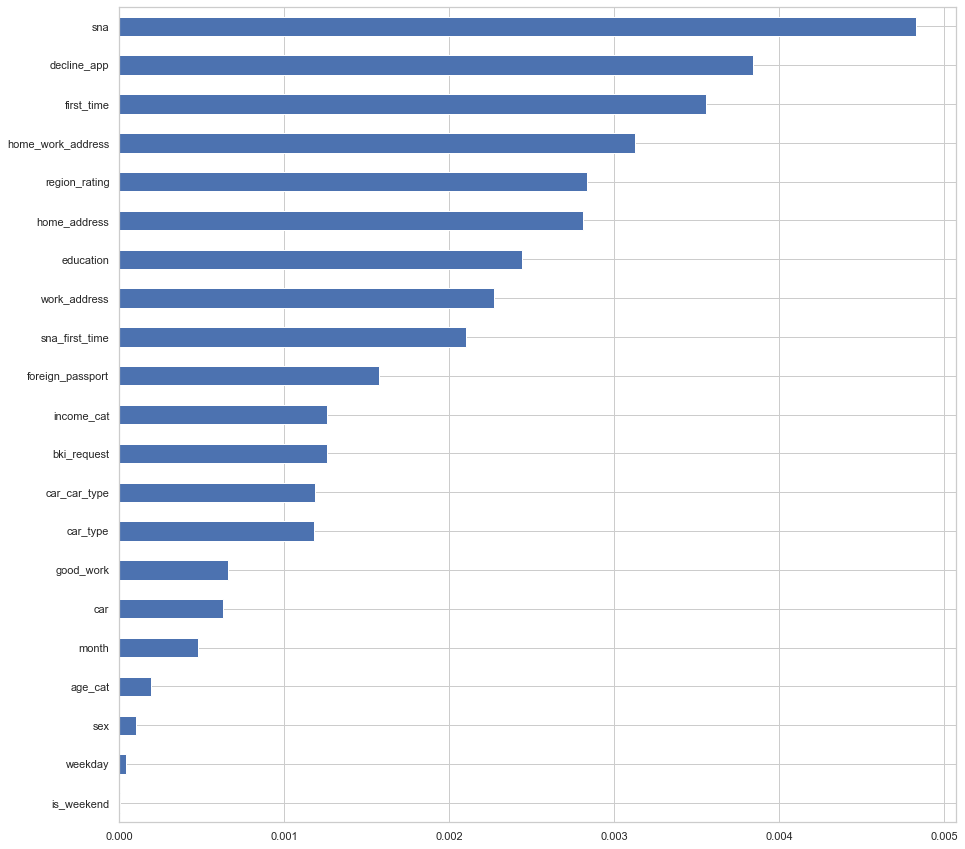

In [1260]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Из коррелирующих между собой переменных удалим age, income. А так же добавим в список удаления категориальные переменные на их основе, так как скорее всего они будут путать модель. Путем экспериментов было выявлено, что так же car_car_type переменная дает худший результат.

In [1261]:
delcol = ['age', 'income', 'age_cat', 'income_cat', 'car_car_type']

Сохраним обработанные данные для экспериментов.

In [1262]:
data1 = data.copy()

# Модели

## Использовал только LogisticRegression

Пробовал undersampling, результат хуже

In [1263]:
data = pd.get_dummies(data, columns=cat_cols)

In [1264]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(client_id)
#data = data.join(sample)
#data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# #undersampling работает хуже
# under_train = pd.concat([train_data[train_data['default']==0].sample(
#     len(train_data[train_data['default']==1]), 
#     random_state=RANDOM_SEED), train_data[train_data['default']==1]])
# y = under_train.default.values            # наш таргет
# X = under_train.drop(['default', 'client_id'], axis=1)


#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

#X = MinMaxScaler(feature_range = (0, 1)).fit_transform(X.values)
X = StandardScaler().fit_transform(X)
#X = RobustScaler().fit_transform(X.values) сработал хуже
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Так же пробовал разные стандартизаторы, результат не менялся.

### LogisticRegression на стандартных настойках и всех данных

confusion_matrix
[[12872    61]
 [ 1775    52]]


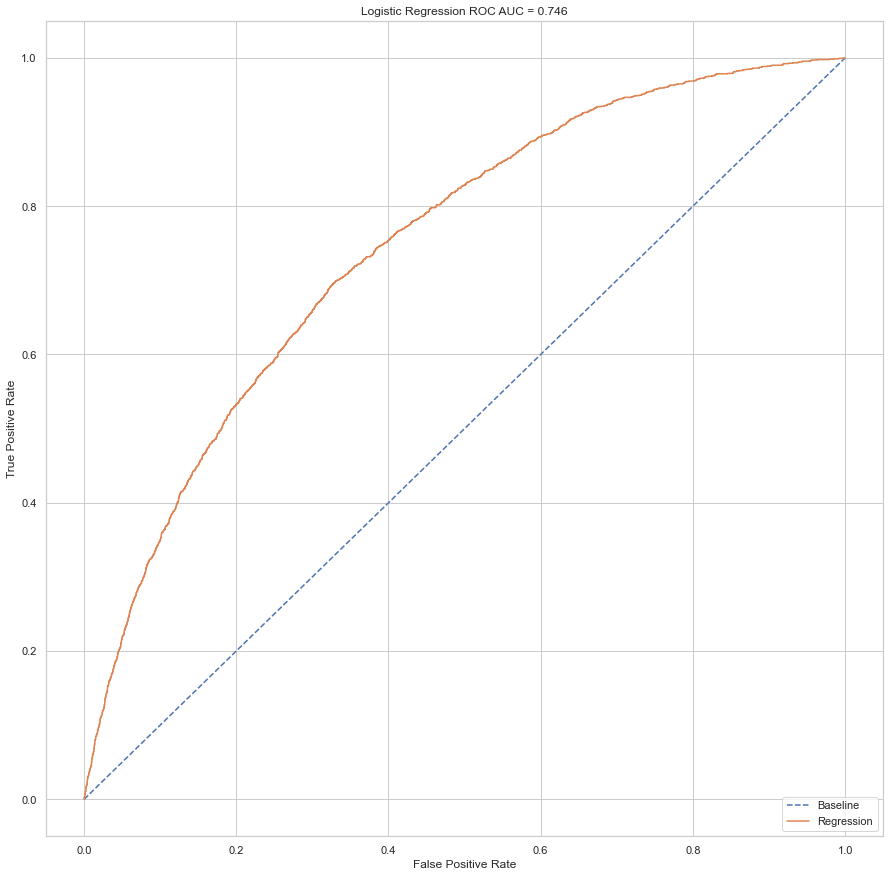

,naive,standart_All
precision,0.0,0.460177
recall,0.0,0.028462
f1-score,0.0,0.053608
support,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]"


In [1265]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['standart_All'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_All']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Модель показала хороший результати по Roc auc. Однако по другим метрикам мы видим сущетственный недостаток модели. по confusion matrix мы видим, что модель достаточно уверенно угадывает клиентов, которые вернут кредит, и только 2% дефолтных клиентов.
Причина может быть в несбалансированности выборки (это мы еще определили в разведовательном анализе). Далее будем использовать баланс классов class_weight='balanced' в настройках модели. Считаю, что recall наилучшим образом будет отражать эффективность нашей модели, так показывает долю угаданных моделью дефолтных клиентов. Попробуем доработать модель, ориентируясь на recall.

### LogisticRegression на стандартных настойках и всех данных с балансом

In [1266]:
data = data1

In [1267]:
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 'income_cat', 
            'car_car_type', 'home_work_address', 'sna_first_time', 'month', 'weekday', 'age_cat']
data = pd.get_dummies(data, columns=cat_cols)

In [1268]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(client_id)
#data = data.join(sample)
#data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

#X = MinMaxScaler(feature_range = (0, 1)).fit_transform(X.values)
X = StandardScaler().fit_transform(X)
#X = RobustScaler().fit_transform(X.values) сработал хуже
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8663 4270]
 [ 563 1264]]


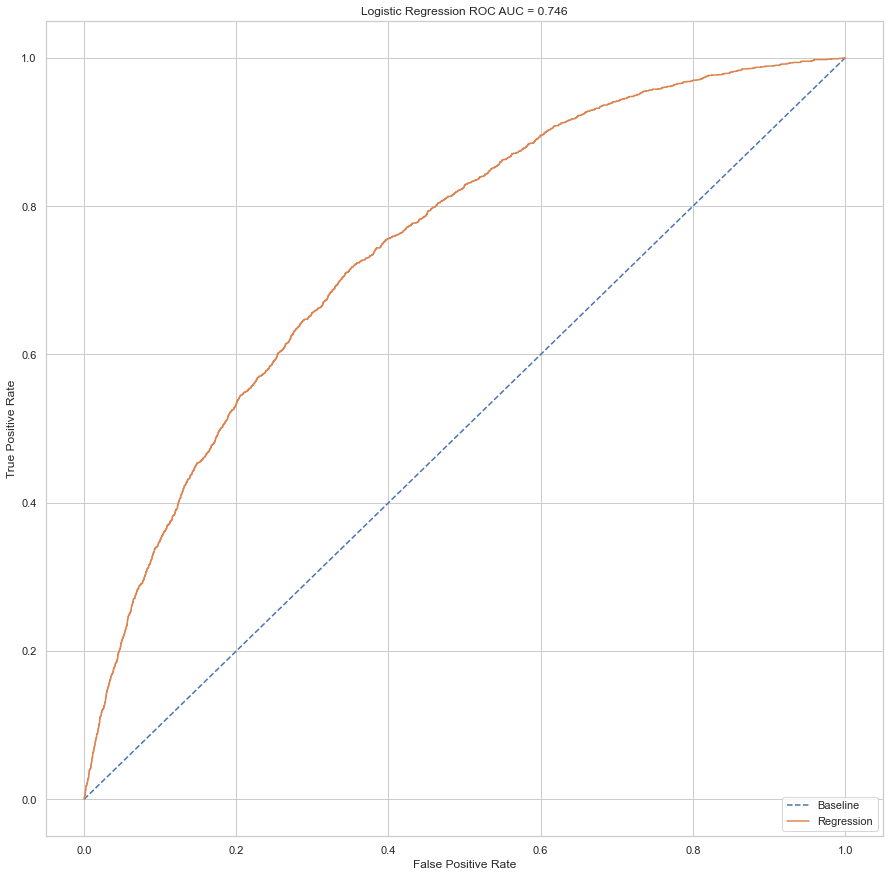

,naive,standart_All,standart_All_bal
precision,0.0,0.460177,0.228406
recall,0.0,0.028462,0.691845
f1-score,0.0,0.053608,0.343432
support,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]"


In [1269]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['standart_All_bal'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_All_bal']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Уже хороший результат, угадываем до 69% дефолтных клиентов. Попробуем эту модель с удаленными мусорными переменными.

### LogisticRegression с балансом с удаленными коррелирующими и малозначительными колонками

In [1270]:
data = data1

In [1271]:
delcol = ['age', 
          'income', 'age_cat', 'income_cat', 
          'car_car_type'
         ]

In [1272]:
data = data.drop(delcol, axis=1)

In [1273]:
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 
            'month', 'weekday', 'sna_first_time', 'home_work_address']

In [1274]:
data = pd.get_dummies(data, columns=cat_cols)

In [1275]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(client_id)
#data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8655 4278]
 [ 578 1249]]


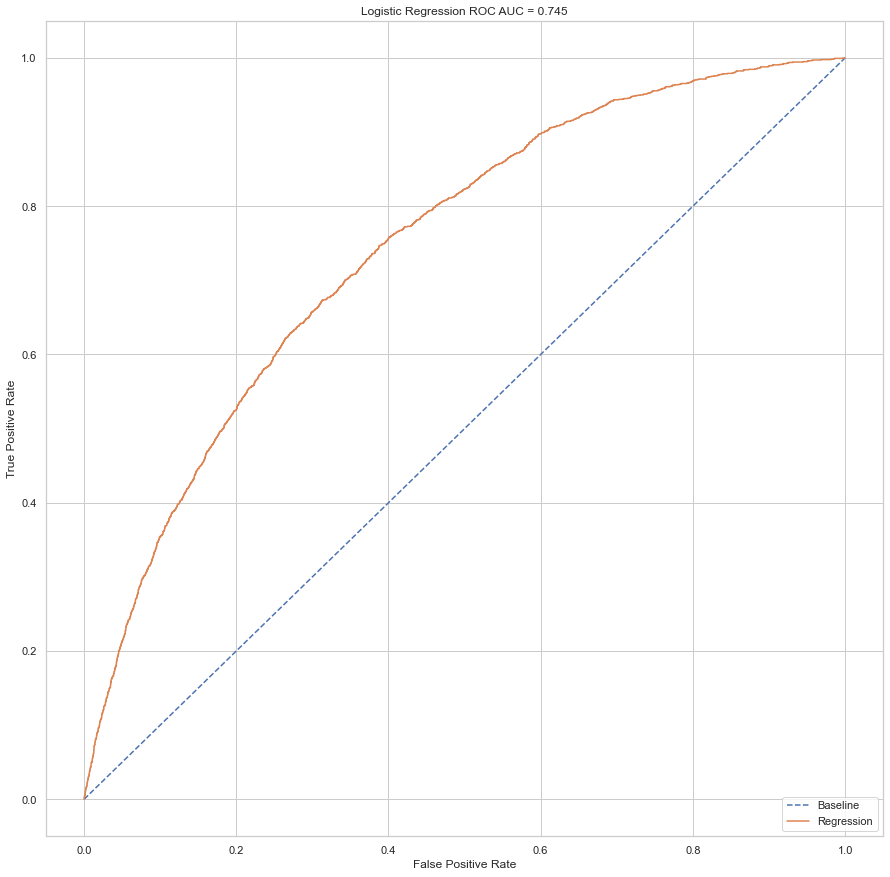

,naive,standart_All,standart_All_bal,standart_bal_manual
precision,0.0,0.460177,0.228406,0.225982
recall,0.0,0.028462,0.691845,0.683634
f1-score,0.0,0.053608,0.343432,0.339679
support,1827.0,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]","[[8655, 4278], [578, 1249]]"


In [1276]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['standart_bal_manual'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_bal_manual']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Результат стал хуже, видимо какая то переменная была важна. Попробуем автоматически выбрать наилучшие переменные.

### LogisticRegression с балансом с автомитически удаленными малозначительными признакмми

In [1277]:
data = data1

In [1278]:
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 'income_cat', 
            'car_car_type', 'home_work_address', 'sna_first_time', 'month', 'weekday', 'age_cat']
data = pd.get_dummies(data, columns=cat_cols)

In [1279]:
data = data.drop(['sample', 'default'], axis=1)

In [1280]:
y = default
data = SelectPercentile(f_classif, percentile=80).fit_transform(data, y)
#data = SelectPercentile(mutual_info_classif, percentile=95).fit_transform(data, y) дает хуже результат, работает долго.

In [1281]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(sample)
data = data.join(client_id)
data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8669 4264]
 [ 562 1265]]


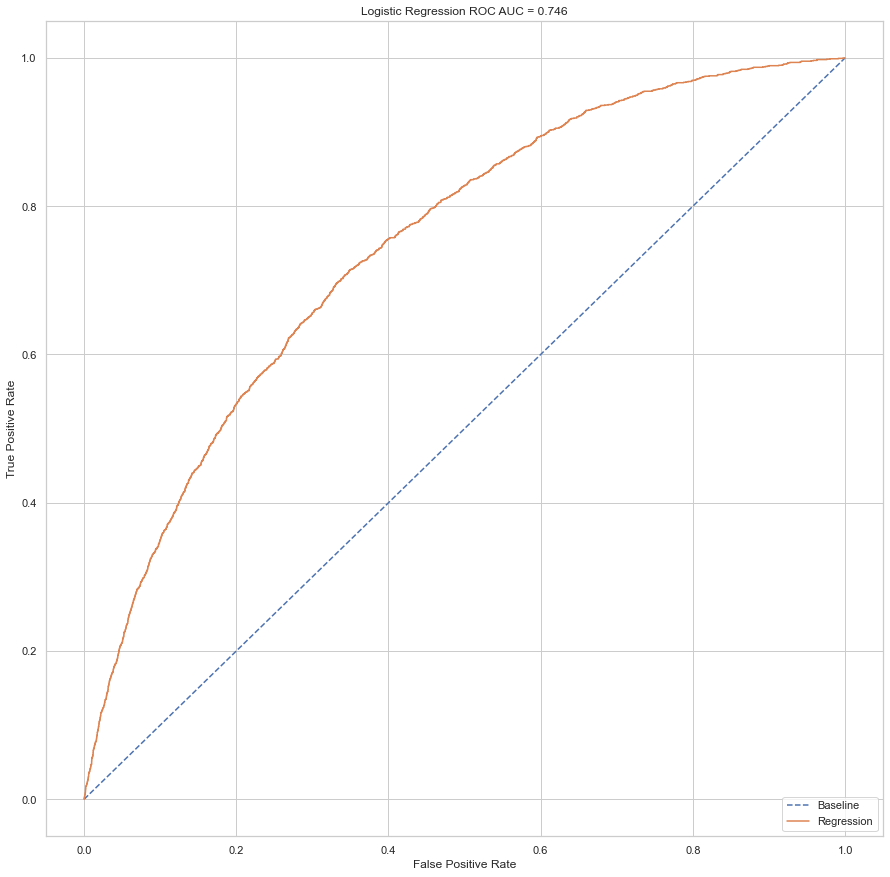

log_loss 0.6012879923215322


,naive,standart_All,standart_All_bal,standart_bal_manual,standart_bal_auto
precision,0.0,0.460177,0.228406,0.225982,0.228794
recall,0.0,0.028462,0.691845,0.683634,0.692392
f1-score,0.0,0.053608,0.343432,0.339679,0.343937
support,1827.0,1827.0,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]","[[8655, 4278], [578, 1249]]","[[8669, 4264], [562, 1265]]"


In [1282]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('log_loss', log_loss(y_test, probs))

data_report['standart_bal_auto'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_bal_auto']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Результат хороший. Попробуем полиноминальные переменные.

### LogisticRegression с балансом и полиноминальные переменные

In [1283]:
data = data1

Возьмем некоторые числовые переменные. После экспериментов остановился на нижеследующих.

In [1284]:
pol_cols = ['age_log', 'bki_request_cnt', 'score_bki', 'day_of_yar']

In [1285]:
poly = PolynomialFeatures(4)
data_pol = poly.fit_transform(data[pol_cols])
data_pol = pd.DataFrame(data_pol)
data = data.join(data_pol)
data = pd.get_dummies(data, columns=cat_cols)

In [1286]:
data = data.drop(['sample', 'default'], axis=1)

Выберем наиболее значимые переменные по f_classif. После экспериментов лучший результат дают 80% переменных.

In [1287]:
y = default
data = SelectPercentile(f_classif, percentile=80).fit_transform(data, y)

In [1288]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(sample)
data = data.join(client_id)
data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8605 4328]
 [ 565 1262]]


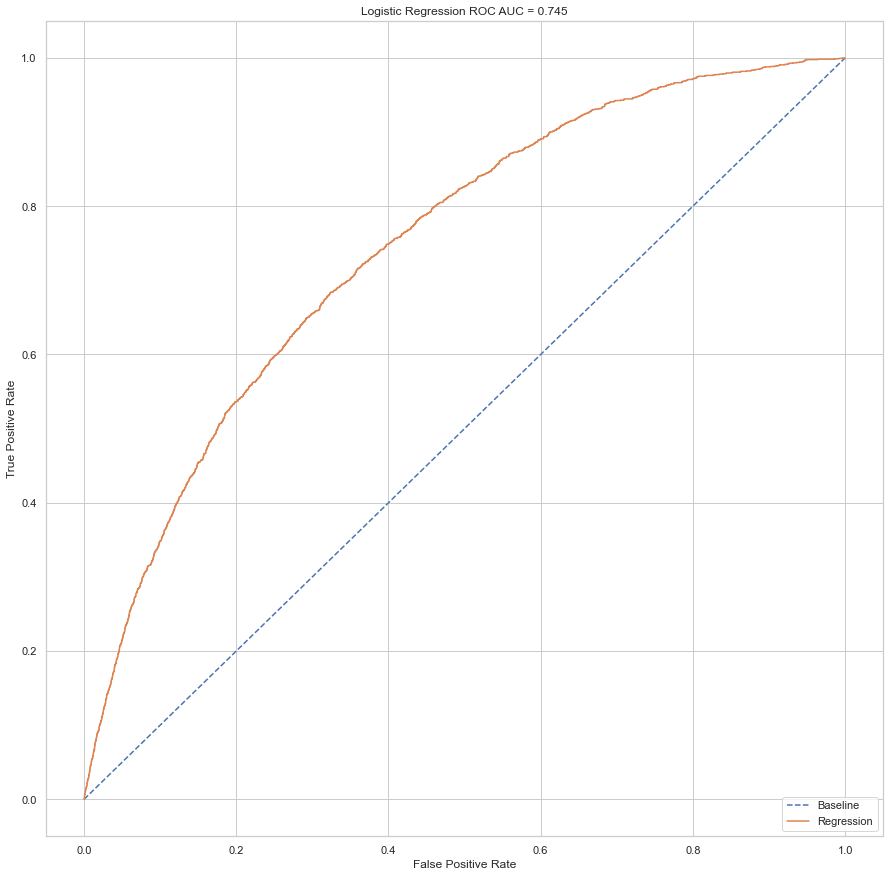

,naive,standart_All,standart_All_bal,standart_bal_manual,standart_bal_auto,standart_bal_pol_auto
precision,0.0,0.460177,0.228406,0.225982,0.228794,0.22576
recall,0.0,0.028462,0.691845,0.683634,0.692392,0.69075
f1-score,0.0,0.053608,0.343432,0.339679,0.343937,0.340299
support,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]","[[8655, 4278], [578, 1249]]","[[8669, 4264], [562, 1265]]","[[8605, 4328], [565, 1262]]"


In [1289]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['standart_bal_pol_auto'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_bal_pol_auto']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Результат слегка ухудшился. Попробуем совмести два метода: удалим вручную мусорные переменные, добавим полиноминальные признаки и автоматически отберем наиболее значимые признаки.

### LogisticRegression с балансом, удаленными мусорными переменными и мультиноминальными переменными

In [1290]:
data = data1

Удалим мусорные переменные

In [1291]:
delcol = ['age', 'income', 'age_cat', 'income_cat', 'car_car_type']

In [1292]:
data = data.drop(delcol, axis=1)

Перепишем список категориальных переменных для OneHotEncoding

In [1293]:
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 
            'month', 'weekday', 'sna_first_time', 'home_work_address']

Для полиноминальных переменных возьмем числовые признаки из предыдущей модели.

In [1294]:
pol_cols = ['age_log', 'bki_request_cnt', 'score_bki', 'day_of_yar']

In [1295]:
poly = PolynomialFeatures(4)
data_pol = poly.fit_transform(data[pol_cols])
data_pol = pd.DataFrame(data_pol)
data = data.join(data_pol)
data = pd.get_dummies(data, columns=cat_cols)

In [1296]:
data = data.drop(['sample', 'default'], axis=1)

Экспериметально подобрал, что 60% переменных отобранных автоматически дают наилучший результат

In [1297]:
y = default
data = SelectPercentile(f_classif, percentile=60).fit_transform(data, y)

In [1298]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(sample)
data = data.join(client_id)
data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8593 4340]
 [ 557 1270]]


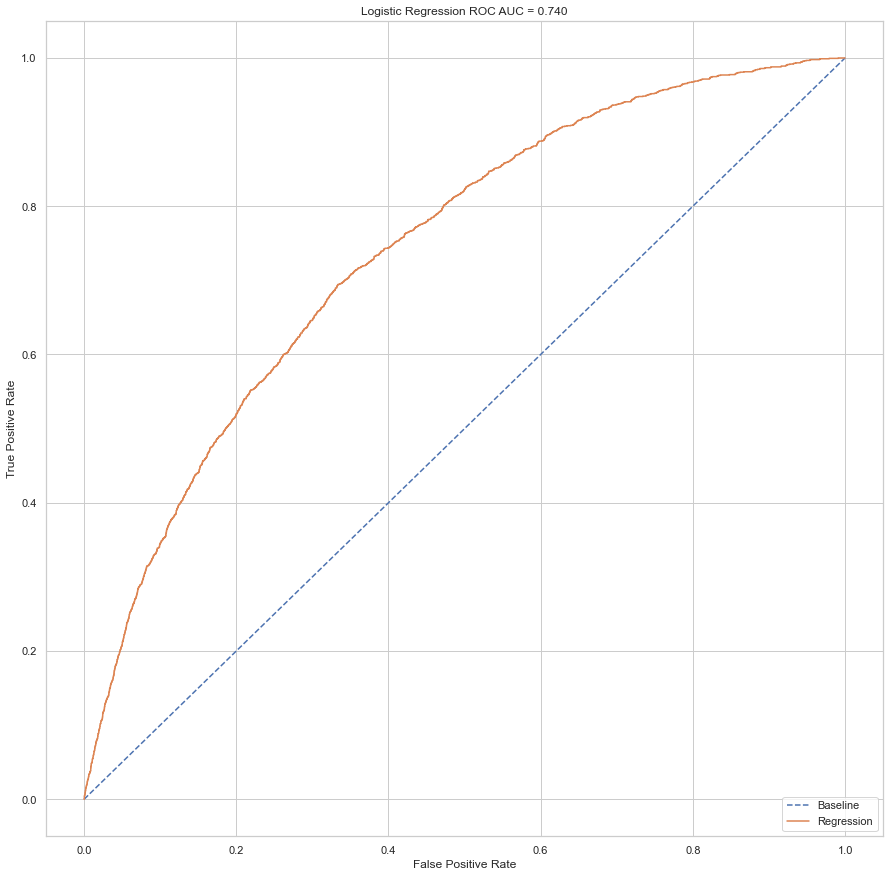

,naive,standart_All,standart_All_bal,standart_bal_manual,standart_bal_auto,standart_bal_pol_auto,standart_bal_pol_auto_manual
precision,0.0,0.460177,0.228406,0.225982,0.228794,0.22576,0.226381
recall,0.0,0.028462,0.691845,0.683634,0.692392,0.69075,0.695129
f1-score,0.0,0.053608,0.343432,0.339679,0.343937,0.340299,0.341536
support,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]","[[8655, 4278], [578, 1249]]","[[8669, 4264], [562, 1265]]","[[8605, 4328], [565, 1262]]","[[8593, 4340], [557, 1270]]"


In [1299]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['standart_bal_pol_auto_manual'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['standart_bal_pol_auto_manual']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Roc auc снизился, зато recall максимальный. Выберем эту модель как основную. Подберем для нее гипермараметры.

### LogisticRegression и GridSearchCV. Попробуем подобрать лучшие гиперпараметры

In [1300]:
data = data1

delcol = ['age', 'income', 'age_cat', 'income_cat', 'car_car_type']
data = data.drop(delcol, axis=1)

cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 
            'month', 'weekday', 'sna_first_time', 'home_work_address']
num_cols = ['age_log', 'bki_request_cnt', 'score_bki', 'day_of_yar']

poly = PolynomialFeatures(4)
data_pol = poly.fit_transform(data[num_cols])
data_pol = pd.DataFrame(data_pol)
data = data.join(data_pol)
data = pd.get_dummies(data, columns=cat_cols)

data = data.drop(['sample', 'default'], axis=1)

y = default
data = SelectPercentile(f_classif, percentile=60).fit_transform(data, y)

In [1301]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(sample)
data = data.join(client_id)
data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1046]:
model = LogisticRegression(max_iter=500)
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2', None]
solver = ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']
# Создадим гиперпараметры
hyperparameters = dict(penalty=penalty, C=C, solver=solver)
Grid = GridSearchCV(model, hyperparameters, cv=4, verbose=0, scoring='roc_auc', n_jobs=4)
Grid.fit(X_train, y_train)
Grid.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Пробовал различные метрики истользовать для выбора лучших параметров в GridSearchCV, roc_auc показал себя лучше

На полученных параметрах обучим модель.

confusion_matrix
[[8584 4349]
 [ 555 1272]]


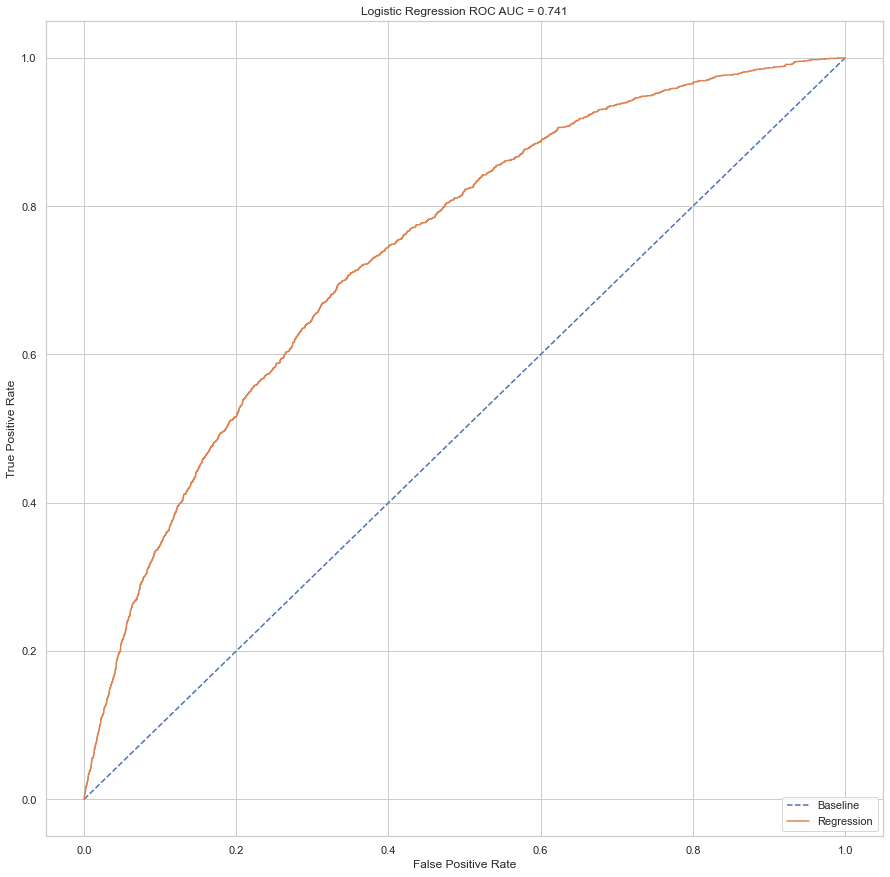

,naive,standart_All,standart_All_bal,standart_bal_manual,standart_bal_auto,standart_bal_pol_auto,standart_bal_pol_auto_manual,GridSearchCV_best
precision,0.0,0.460177,0.228406,0.225982,0.228794,0.22576,0.226381,0.226294
recall,0.0,0.028462,0.691845,0.683634,0.692392,0.69075,0.695129,0.696223
f1-score,0.0,0.053608,0.343432,0.339679,0.343937,0.340299,0.341536,0.341568
support,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0,1827.0
confusion_matrix,"[[12933, 0], [1827, 0]]","[[12872, 61], [1775, 52]]","[[8663, 4270], [563, 1264]]","[[8655, 4278], [578, 1249]]","[[8669, 4264], [562, 1265]]","[[8605, 4328], [565, 1262]]","[[8593, 4340], [557, 1270]]","[[8584, 4349], [555, 1272]]"


In [1302]:
model = LogisticRegression(penalty='l2',
                           C=0.01,
                           class_weight='balanced',
                           solver='liblinear'
                           )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

data_report['GridSearchCV_best'] = pd.DataFrame(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['1'])
data_report = data_report.astype(object)
data_report['GridSearchCV_best']['confusion_matrix'] = confusion_matrix(y_test, y_pred)
data_report

Не смотря на то, что модель показала на Каггле не самые лучшие результаты, я считаю эта модель лучше справляется с задачей скоринга. Она угадывает по нашим метрикам до 70% дефолтных клиентов, хотя и теряет до 34% лояльных клиентов. Модель все еще требует доработки, возможно стояло бы попробовать более продвинутые классификаторы, вернутся к выбору признаков, попробовать поискать новые зависимости.

### Отправим результаты на Каггл

In [1149]:
test_data = test_data.drop(['default'], axis=1)
test_client_id = pd.DataFrame()
test_client_id['client_id'] = test_data['client_id']
test_data = test_data.drop(['client_id'], axis=1)
test_data = StandardScaler().fit_transform(test_data.values)
predict_submission = model.predict_proba(test_data)
test_client_id['default'] = predict_submission[:,1]
test_client_id.to_csv('submission.csv', index=False)
test_client_id.head(10)

,client_id,default
0,74835,0.201226
1,17527,0.801996
2,75683,0.273125
3,26883,0.328780
4,28862,0.172225
5,99881,0.626559
6,26630,0.826211
7,79934,0.182191
8,16605,0.145410
9,105449,0.104695
